In [1]:
library(tidyverse)
library(stringr)
library(lubridate)
library(modelr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
crash <- read_csv("chicagotraffic2019.csv") #%>% print(width=Inf)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_character(),
  X1 = col_double(),
  POSTED_SPEED_LIMIT = col_double(),
  LANE_CNT = col_double(),
  STREET_NO = col_double(),
  BEAT_OF_OCCURRENCE = col_double(),
  NUM_UNITS = col_double(),
  INJURIES_TOTAL = col_double(),
  INJURIES_FATAL = col_double(),
  INJURIES_INCAPACITATING = col_double(),
  INJURIES_NON_INCAPACITATING = col_double(),
  INJURIES_REPORTED_NOT_EVIDENT = col_double(),
  INJURIES_NO_INDICATION = col_double(),
  INJURIES_UNKNOWN = col_double(),
  CRASH_HOUR = col_double(),
  CRASH_DAY_OF_WEEK = col_double(),
  CRASH_MONTH = col_double(),
  LATITUDE = col_double(),
  LONGITUDE = col_double()
)

See spec(...) for full column specifications.



We want to find out when is the difference between the time police is notified and the time the crash happens the smallest. Then, we will investigate the potential causes that led to our finding. 
We are given the exact time for both the time police was notified and the time the crash happened, in order to make the graphs easier to interpret, we divide the 24 hours into 4 parts - morning, afternoon, evening, and night. We will then investigate at what time of day is the time difference between the two times the smallest.  


In [3]:
breaks <- hour(hm("00:00", "6:00", "12:00", "18:00", "23:59"))
labels <- c("Night", "Morning", "Afternoon", "Evening")
crash1 <- crash %>% mutate(time = mdy_hms(CRASH_DATE))  %>% 
mutate(Time_of_day = cut(x=hour(time), breaks = breaks, labels = labels, include.lowest=TRUE))


Now, we will creat a new variable called time_diff which represents the time people spent before notifying the police. 


Warning message:
“Removed 51762 rows containing non-finite values (stat_boxplot).”


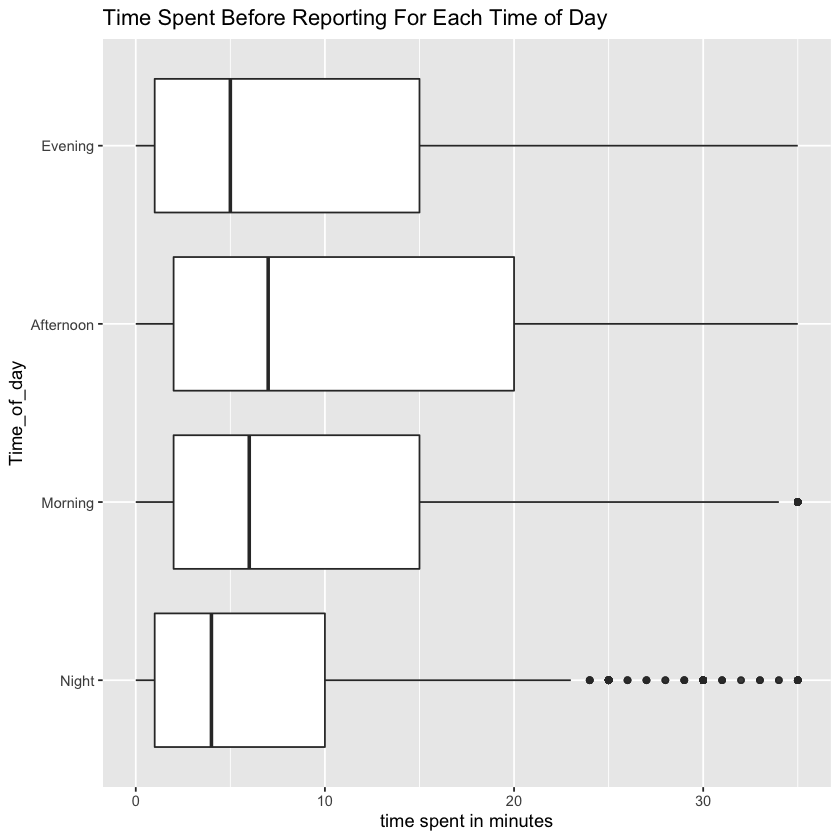

In [4]:
crash2 <- crash1 %>% mutate(time_notified = mdy_hms(DATE_POLICE_NOTIFIED),
                            time_diff = difftime(time_notified, time,units = "mins"))

ggplot(crash2) +geom_boxplot(mapping = aes(x=time_diff,y=Time_of_day),outlier.alpha = 0.1)+ 
scale_x_continuous(limits = c(0,35)) + 
labs(title = "Time Spent Before Reporting For Each Time of Day",x = "time spent in minutes")


Using the box plot, we obtain the quartiles and medians of time spent before reporting for each time of day. We observe that people report faster at night and slowest in the afternoon on average. In addition, the time spent before reporting is most concentrated at night and most sparse in the afternoon since the range of the variable time_diff is smallest at night and largest in the afternoon. 
We want to investigate what caused this. 


In [5]:
crash2 %>% group_by(Time_of_day,CRASH_TYPE) %>% summarize(num = n()) %>% spread(key = CRASH_TYPE, value = num) %>%
group_by(Time_of_day) %>% 
summarize(`percent of accidents involving injuries` = 
          `INJURY AND / OR TOW DUE TO CRASH`/(`INJURY AND / OR TOW DUE TO CRASH` +
                                                        `NO INJURY / DRIVE AWAY` )*100)


`summarise()` regrouping output by 'Time_of_day' (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



Time_of_day,percent of accidents involving injuries
<fct>,<dbl>
Night,40.92678
Morning,23.34517
Afternoon,23.21815
Evening,30.49465


Constructing the table above, we found that the percentage of crashes involving injuries is significantly higher at night than at any other time of day. In fact, the crashes involving injuries at night is at 40.93% (highest among the four) while in the afternoon it is 23.22% (lowest among the four). This suggests that whether crashes involving injuries is a factor in impacting the time people spend before reporting. People are more likely to report faster when there are injuries involved than there is not. 
To further support this statement, we plotted the boxplot below.


Warning message:
“Removed 30615 rows containing non-finite values (stat_boxplot).”


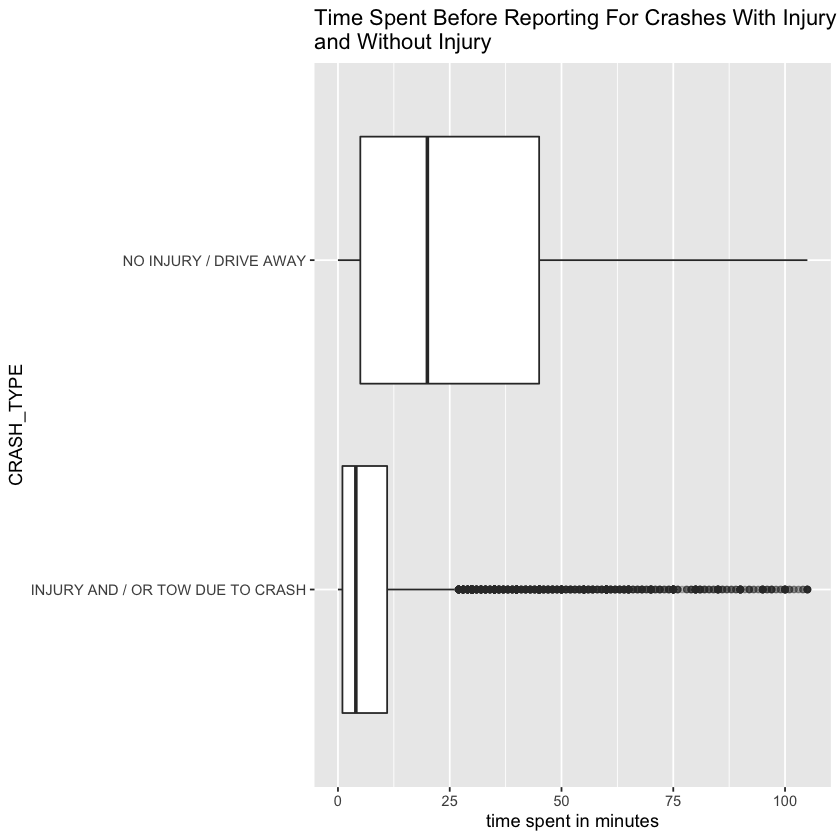

In [6]:
ggplot(crash2) +geom_boxplot(mapping = aes(x=time_diff,y=CRASH_TYPE),outlier.alpha = 0.1)+ 
scale_x_continuous(limits = c(0,105))+ 
labs(title = "Time Spent Before Reporting For Crashes With Injury\nand Without Injury",x = "time spent in minutes")


The box plot shows an obvious trend, that accidents involving injuries are reported at a significantly faster speed on average. The range for the time is also significantly smaller, indicating that most people almost do not hesitate before reporting.


Is there also a connection between the severity of the injury and the time spend before reporting? We filtered out all crashes that do not involve fatality.


Warning message:
“Removed 8 rows containing non-finite values (stat_boxplot).”


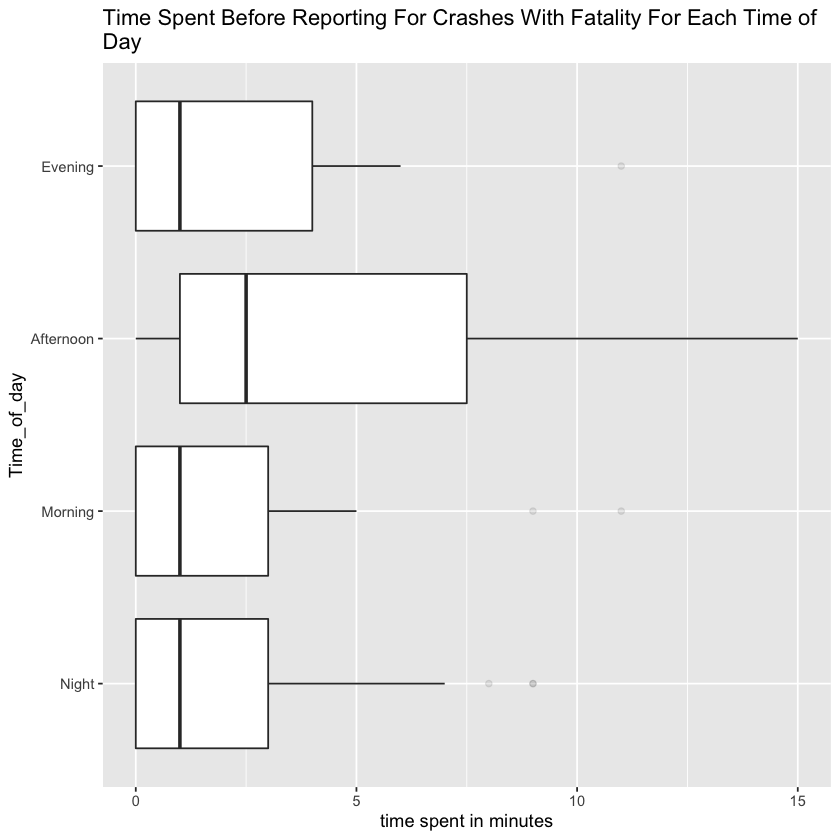

In [7]:
crash2 %>% filter(INJURIES_FATAL != 0) %>% 
ggplot() + geom_boxplot(mapping = aes(x=time_diff,y=Time_of_day),outlier.alpha = 0.1)+ 
scale_x_continuous(limits = c(0,15))+ 
labs(title = "Time Spent Before Reporting For Crashes With Fatality For Each Time of\nDay",
     x = "time spent in minutes")


According to the boxplot, there is a striking similarity between the time people spend before reporting at night,in the evening, in the morning, and in the afternoon among fatal crashes. The afternoon has a relatively larger range, but considering that the sample size for afternoon fatal crashes is only 20 (as shown in table below), we suspect the slight deviation in range could be due to a not large enough sample size. Comparing this box plot to the two box plots above, we see that serious injury does lead to faster report.


In [8]:
crash2 %>% filter(INJURIES_FATAL != 0) %>% group_by(Time_of_day) %>% 
summarize(`number of accidents involving fatality`=n())


`summarise()` ungrouping output (override with `.groups` argument)



Time_of_day,number of accidents involving fatality
<fct>,<int>
Night,34
Morning,24
Afternoon,20
Evening,24


Finally, we want to investigate, in cases where the victims involved in the traffic were unable to report the crash themselves due to injury, would the report time in turn be affected. This finding is important. For example, injuries happen most often at night, and if severely injured people are not discovered soon enough by others at night due to less traffic or darkness, this might lead to potential death.


To do this, we will create a new variable called tot_ppl, which represents the total number of people involved in each crash by adding up the number of total injuries, injuries without indication, and unknown injuries. Next, we assume that the people who died and the people who were incapacitated during the crash were not able to report the crash to the police themselves since they were severely injured. Therefore, we are able to create a report type, that if the total number of people involved in the crash equals the total number of fatality plus incapacitated, the crash would be reported by others. Otherwise, the victims in the crash were not severely injured and the report would be classified as self-report since the victims were able to report by themselves. 

Warning message:
“Removed 68569 rows containing non-finite values (stat_boxplot).”


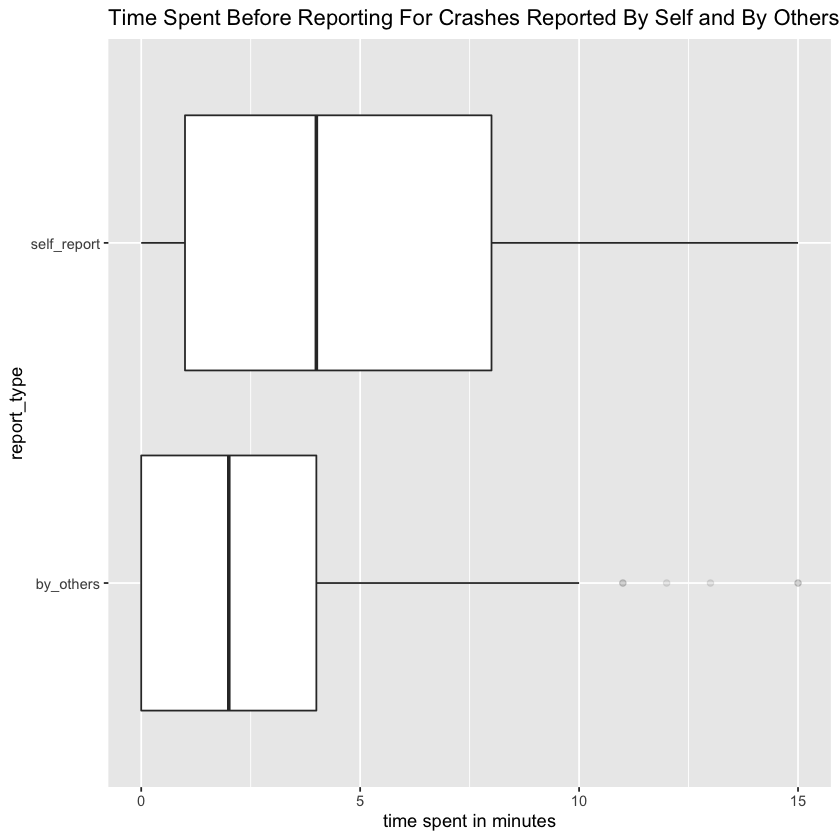

In [9]:
crash2 %>% 
mutate(tot_ppl = INJURIES_TOTAL + INJURIES_NO_INDICATION + INJURIES_UNKNOWN, 
       report_type = ifelse(tot_ppl ==INJURIES_FATAL + INJURIES_INCAPACITATING,"by_others","self_report")) %>% 
filter(!is.na(report_type)) %>%
ggplot() + geom_boxplot(mapping = aes(x=time_diff,y=report_type),outlier.alpha = 0.1)+ 
scale_x_continuous(limits = c(0,15))+ 
labs(title = "Time Spent Before Reporting For Crashes Reported By Self and By Others",x = "time spent in minutes")


We find that self-report takes longer than reported-by-others. In cases where victims were unable to report due to injury, other people would report for them quickly. Longer self report time could be due to the fact that people tend to negotiate when crashes are not serious. We now want to find if the time of day influences the time it takes for others to report. For instance, people might take longer to report at night due to less traffic and therefore crashes are less likely and slower to be discovered. We now need to filter out the self-report type. 


Warning message:
“Removed 33 rows containing non-finite values (stat_boxplot).”


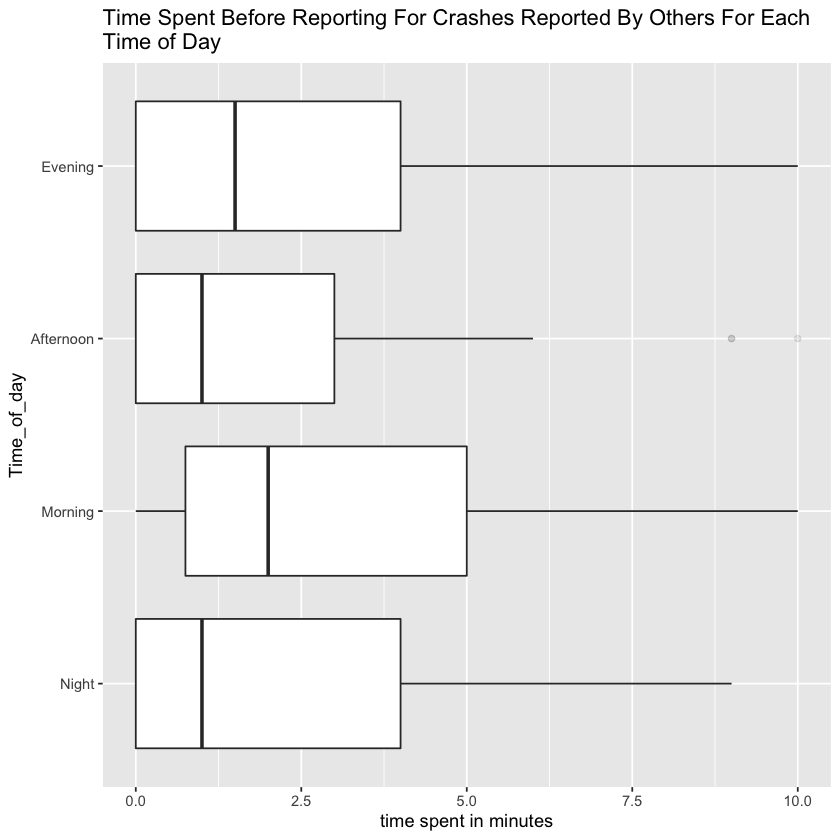

In [10]:
crash2 %>% 
mutate(tot_ppl = INJURIES_TOTAL + INJURIES_NO_INDICATION + INJURIES_UNKNOWN, 
       report_type = ifelse(tot_ppl ==INJURIES_FATAL + INJURIES_INCAPACITATING,"by_others","self_report")) %>%
filter(report_type == "by_others") %>% 
ggplot()+ geom_boxplot(mapping = aes(x=time_diff,y=Time_of_day),outlier.alpha = 0.1)+ 
scale_x_continuous(limits = c(0,10))+ 
labs(title = "Time Spent Before Reporting For Crashes Reported By Others For Each\nTime of Day",
     x = "time spent in minutes")


As shown, the time of day does not have a major impact on the time others spend for reporting. Therefore, we do not need to worry that at Chicago night, severe crashes will not be discovered fast enough and will lead to unnecessary deaths. 

Lastly, we will use the linear regression model to predict the time spend before reporting in terms of two factors: the cost of damage and whether the crash is fatal. 

In [11]:
m1 <- lm(as.numeric(time_diff) ~ DAMAGE , data = crash2)
summary(m1)


Call:
lm(formula = as.numeric(time_diff) ~ DAMAGE, data = crash2)

Residuals:
   Min     1Q Median     3Q    Max 
  -943   -837   -656   -591 588569 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)           850.69      40.20  21.161  < 2e-16 ***
DAMAGE$501 - $1,500    91.97      48.56   1.894   0.0583 .  
DAMAGEOVER $1,500    -189.63      44.58  -4.254  2.1e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5027 on 117745 degrees of freedom
Multiple R-squared:  0.0006461,	Adjusted R-squared:  0.0006292 
F-statistic: 38.06 on 2 and 117745 DF,  p-value: < 2.2e-16


In [12]:
t1 <- crash2 %>% mutate(fatality = ifelse(INJURIES_FATAL != 0,"Fatal crash","No Fatality")) 
m2 <- lm(as.numeric(time_diff) ~ fatality , data = t1)
summary(m2)


Call:
lm(formula = as.numeric(time_diff) ~ fatality, data = t1)

Residuals:
   Min     1Q Median     3Q    Max 
  -768   -763   -740   -648 588652 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)
(Intercept)             38.5      498.1   0.077    0.938
fatalityNo Fatality    729.6      498.3   1.464    0.143

Residual standard error: 5031 on 117481 degrees of freedom
  (265 observations deleted due to missingness)
Multiple R-squared:  1.825e-05,	Adjusted R-squared:  9.735e-06 
F-statistic: 2.144 on 1 and 117481 DF,  p-value: 0.1432


In [13]:
m3 <- lm(as.numeric(time_diff) ~ DAMAGE+fatality, data = t1)
summary(m3)


Call:
lm(formula = as.numeric(time_diff) ~ DAMAGE + fatality, data = t1)

Residuals:
   Min     1Q Median     3Q    Max 
  -942   -837   -657   -592 588569 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)           187.25     499.45   0.375   0.7077    
DAMAGE$501 - $1,500    90.23      48.65   1.855   0.0636 .  
DAMAGEOVER $1,500    -189.33      44.66  -4.239 2.25e-05 ***
fatalityNo Fatality   664.19     498.24   1.333   0.1825    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5029 on 117479 degrees of freedom
  (265 observations deleted due to missingness)
Multiple R-squared:  0.0006554,	Adjusted R-squared:  0.0006299 
F-statistic: 25.68 on 3 and 117479 DF,  p-value: < 2.2e-16


[interpretation......]

In conclusion, people report faster at night on average because 1. crashes involving injuries happen most often at night at 40.93% and people tend to report faster when injury is involved. People also report faster when injuries are  serious and fatal. Lastly, self report takes longer than report-by-others and the time it takes for others to report is not related to the time of day the crash happened. Thus, we don't need to worry that nobody will report the crash when victims are unable to report. 
